# Projet de prédiction du risque de défaut de crédit

In [919]:
# Importation des librairies nécessaires

import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
import seaborn as sns
from scipy.stats import zscore
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler # Moved import here
import joblib      # Pour sauvegarder le modèle entrainé


In [920]:
# Installer et vérifier ipywidgets dans l'environnement du kernel
#import sys
#import subprocess
#from IPython.display import display

#print("Python executable:", sys.executable)

#try:
    #import ipywidgets as widgets
    #print("ipywidgets déjà installé, version:", widgets.__version__)
#except Exception:
    #print("Installation de ipywidgets, widgetsnbextension et jupyterlab_widgets...")
    #subprocess.check_call([sys.executable, "-m", "pip", "install", "ipywidgets", "widgetsnbextension", "jupyterlab_widgets"])
    #try:
        #subprocess.check_call([sys.executable, "-m", "jupyter", "nbextension", "enable", "--py", "widgetsnbextension", "--sys-prefix"])
    #except Exception as e:
        #print("Activation de nbextension impossible (non bloquant):", e)
    #print("Installation terminée. Redémarrez le kernel si nécessaire.")

# Test rapide
#import importlib
#importlib.invalidate_caches()
#try:
    #import ipywidgets as widgets
# display(widgets.IntSlider(value=42))
    #print("Test terminé : le widget devrait s'afficher ci-dessus.")
#except Exception as e:
    #print("Échec du test :", e)


# IMPORTATION DE LA DATAFRAME ET MANIPULATION

**Informations sur l'ensemble de données**

Cet ensemble de données contient des informations sur les paiements en défaut, les facteurs démographiques, les données de crédit, l'historique des paiements et les relevés de compte des clients de cartes de crédit à Taïwan d'avril 2005 à septembre 2005.

**Contenu**

Il y a 25 variables :

ID : Identifiant de chaque client
LIMIT_BAL : Montant du crédit accordé en dollars NT (incluant les crédits individuels et familiaux/supplémentaires)
SEXE : Genre (1=homme, 2=femme)
ÉDUCATION : (1=études supérieures, 2=université, 3=lycée, 4=autres, 5=inconnu, 6=inconnu)
MARIAGE : État civil (1=marié, 2=célibataire, 3=autre)
ÂGE : Âge en années
PAY_0 : État du remboursement en septembre 2005 (-1=paiement à l'échéance, 1=retard de paiement d'un mois, 2=retard de paiement de deux mois, … 8=retard de paiement de huit mois, 9=retard de paiement de neuf mois et plus)
PAY_2 : État des remboursements en août 2005 (échelle identique à celle ci-dessus)
PAY_3 : État du remboursement en juillet 2005 (échelle identique à celle ci-dessus)
PAY_4 : État des remboursements en juin 2005 (échelle identique à celle ci-dessus)
PAY_5 : État du remboursement en mai 2005 (échelle identique à celle ci-dessus)
PAY_6 : État des remboursements en avril 2005 (échelle identique à celle ci-dessus)
BILL_AMT1 : Montant de la facture de septembre 2005 (dollar NT)
BILL_AMT2 : Montant de la facture en août 2005 (dollar NT)
BILL_AMT3 : Montant de la facture de juillet 2005 (dollar NT)
BILL_AMT4 : Montant de la facture de juin 2005 (dollar NT)
BILL_AMT5 : Montant de la facture de mai 2005 (dollar NT)
BILL_AMT6 : Montant de la facture d'avril 2005 (dollar NT)
PAY_AMT1 : Montant du paiement précédent en septembre 2005 (dollar NT)
PAY_AMT2 : Montant du paiement précédent en août 2005 (dollar NT)
PAY_AMT3 : Montant du paiement précédent en juillet 2005 (dollar NT)
PAY_AMT4 : Montant du paiement précédent en juin 2005 (dollar NT)
PAY_AMT5 : Montant du paiement précédent en mai 2005 (dollar NT)
PAY_AMT6 : Montant du paiement précédent en avril 2005 (dollar NT)
default.payment.next.month : Paiement par défaut (1=oui, 0=non)

**Inspiration**

Quelques pistes d'exploration :

###1)Comment la probabilité de défaut de paiement varie-t-elle selon les différentes variables démographiques ?
###2)Quelles sont les variables qui prédisent le mieux un défaut de paiement ?




In [921]:
data=pd.read_csv('UCI_Credit_Card.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [922]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [923]:
data.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [924]:
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [925]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [1004]:
data['PAY_6'].unique()

array([-1,  2,  3,  6,  4,  7,  8,  5])

In [927]:
# Regrouper certaines catégotires de certaines variables

data['EDUCATION']=data['EDUCATION'].replace({0:4, 5:4, 6:4,2:1})
data['MARRIAGE']=data['MARRIAGE'].replace({0:3})
data['PAY_0']=data['PAY_0'].replace({0:-1,-2:-1})
data['PAY_2']=data['PAY_2'].replace({0:-1,-2:-1})
data['PAY_3']=data['PAY_3'].replace({0:-1,-2:-1})
data['PAY_4']=data['PAY_4'].replace({0:-1,-2:-1})
data['PAY_5']=data['PAY_5'].replace({0:-1,-2:-1})
data['PAY_6']=data['PAY_6'].replace({0:-1,-2:-1})
#data['PAY_6'].unique()

In [928]:
data=data.drop(columns=['ID'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

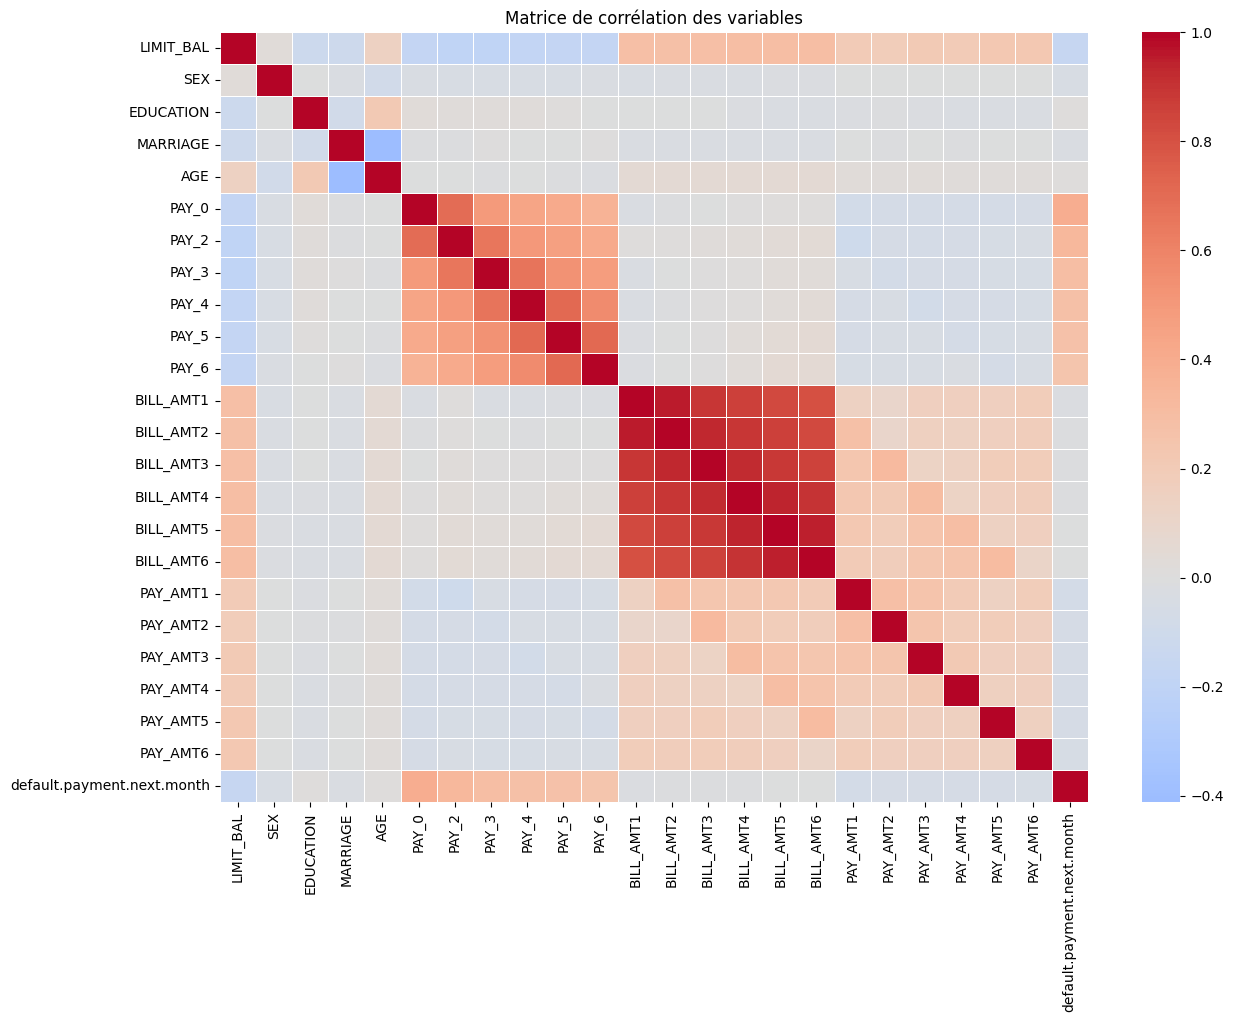

In [929]:
corr=data.corr(method='pearson')
corr.round(2)

#Visualisation de la matrice de corrélation

corr = data.corr(method='pearson')

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr,
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title("Matrice de corrélation des variables")
plt.show()

In [930]:
categoricals_cols=data.nunique()[data.nunique()<10].keys().tolist()
categoricals_cols

['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'default.payment.next.month']

In [931]:
# Visualisation des graphiques en barplot pour les variables ctégorielles

def barplot(a):
    data[a].value_counts(normalize=True).plot(kind='bar')
    plt.ylabel('proportion')
    plt.title('Distribution of'+ str(a))
    return plt.show()

In [932]:
from ipywidgets import interact 
interact(barplot, a=categoricals_cols)

interactive(children=(Dropdown(description='a', options=('SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PA…

<function __main__.barplot(a)>

In [933]:
numerical_cols=data.nunique()[data.nunique()>=10].keys().tolist()
numerical_cols

['LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [934]:
# Visulisation des histogrammes pour les variables numériques à valeurs uniques >=10

def hist_plot(b):
    sns.histplot(data[b], kde=False)
    plt.title('Histogram of'+ str(b))
    return plt.show()

In [935]:
interact(hist_plot, b=numerical_cols)

interactive(children=(Dropdown(description='b', options=('LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_A…

<function __main__.hist_plot(b)>

In [936]:
# Graphique en boxplot
def box_plot(b):
    sns.boxplot(y=data[b])
    plt.title('Boxplot of'+ str(b))
    return plt.show()

In [937]:
interact(box_plot, b=numerical_cols)

interactive(children=(Dropdown(description='b', options=('LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_A…

<function __main__.box_plot(b)>

Text(0.5, 1.0, 'Relation entre le défaut de crédit et le montant de crédit accordé')

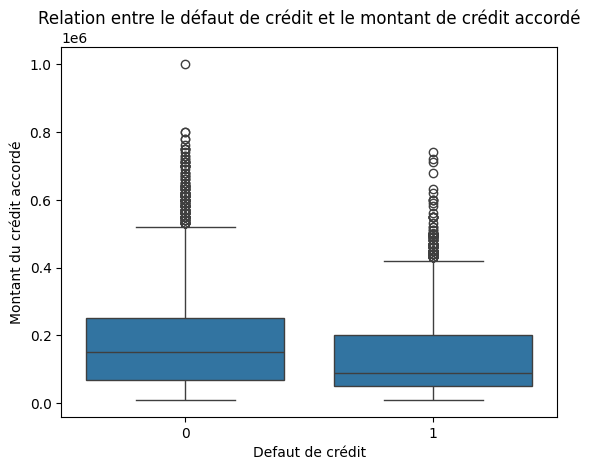

In [938]:
# Craphique pour visualiser la relation entre la cible et la variable LIMIT_BAL

sns.boxplot(x='default.payment.next.month', y='LIMIT_BAL', data=data)
plt.xlabel('Defaut de crédit')
plt.ylabel('Montant du crédit accordé')
plt.title('Relation entre le défaut de crédit et le montant de crédit accordé')

Text(0.5, 1.0, 'Relation entre le défaut de crédit et âge du client')

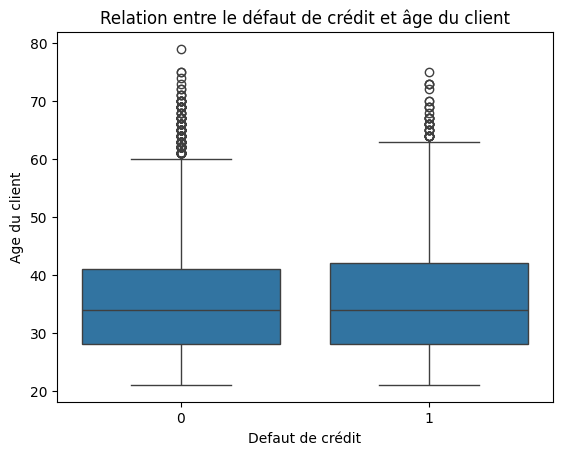

In [939]:
# Relation entre la cible et la variable AGE
sns.boxplot(x='default.payment.next.month', y='AGE', data=data)
plt.xlabel('Defaut de crédit')
plt.ylabel('Age du client')
plt.title('Relation entre le défaut de crédit et âge du client')

Text(0.5, 1.0, 'Relation entre le défaut de crédit et Montant de la facture de septembre 2005')

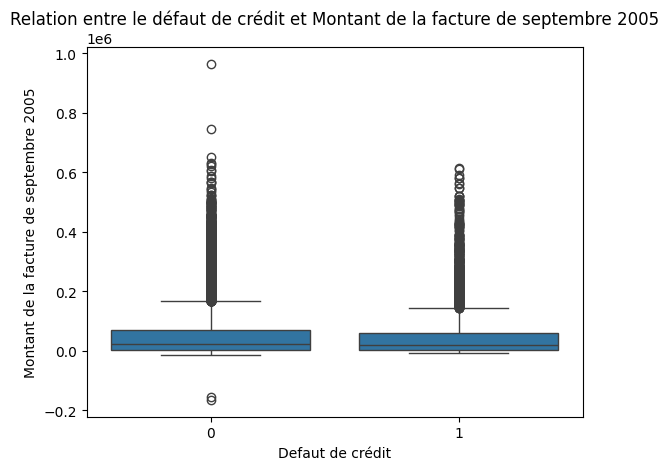

In [940]:
# Relation entre la cible et la variable BILL_AMT1

sns.boxplot(x='default.payment.next.month', y='BILL_AMT1', data=data)
plt.xlabel('Defaut de crédit')
plt.ylabel('Montant de la facture de septembre 2005')
plt.title('Relation entre le défaut de crédit et Montant de la facture de septembre 2005')

Text(0.5, 1.0, 'Relation entre le défaut de crédit et Montant du paiement précédent en septembre 2005')

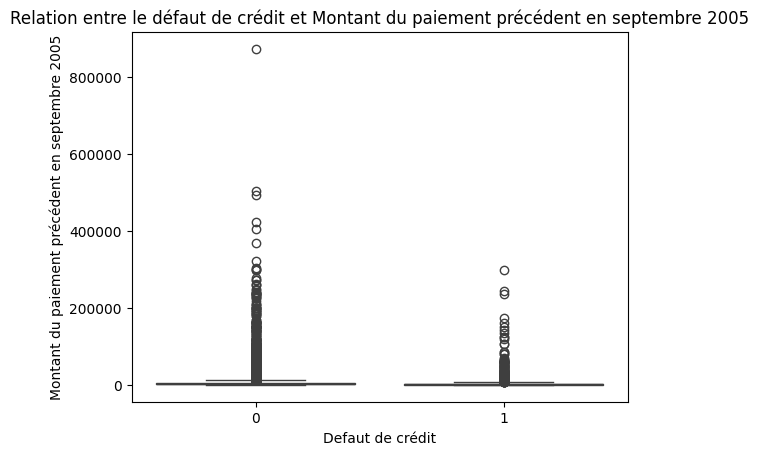

In [941]:
# Relation entre la cible et la variable PAY_AMT1

sns.boxplot(x='default.payment.next.month', y='PAY_AMT1', data=data)
plt.xlabel('Defaut de crédit')
plt.ylabel('Montant du paiement précédent en septembre 2005')
plt.title('Relation entre le défaut de crédit et Montant du paiement précédent en septembre 2005')

In [942]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

In [943]:
# Créer des étiquettes lisibles pour PAY_0 (état du remboursement en septembre 2005)
#mapping = {
    #-1: "À l'échéance",
    #1: "Retard 1 mois",
    #2: "Retard 2 mois",
    #3: "Retard 3 mois",
    #4: "Retard 4 mois",
    #5: "Retard 5 mois",
    #6: "Retard 6 mois",
    #7: "Retard 7 mois",
    #8: "Retard 8 mois ou plus"
#}
#data['PAY_0'] = data['PAY_0'].map(mapping)

# Graphique pour visualiser la relation entre la cible et la variable PAY_0
#colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]  # palette de 9 couleurs distinctes
#sns.boxplot(x='default.payment.next.month', y='PAY_0', data=data, hue='PAY_0', palette=colors)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.title('Relation entre défaut et état du remboursement (septembre 2005)')
#plt.show()


<Axes: xlabel='default.payment.next.month', ylabel='EDUCATION'>

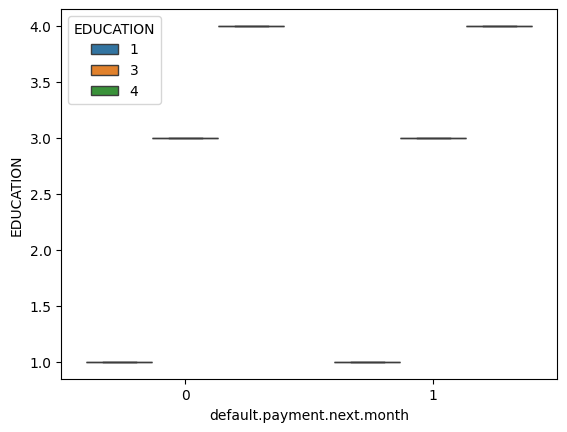

In [944]:
# Graphique pour visualiser la relation entre la cible et la variable PAY_0
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # palette de 9 couleurs distinctes
sns.boxplot(x='default.payment.next.month', y='EDUCATION', data=data, hue='EDUCATION', palette=colors)



C:\Users\ousma\AppData\Local\Temp\ipykernel_24660\2871594123.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='default.payment.next.month', data=data, palette='Set1')


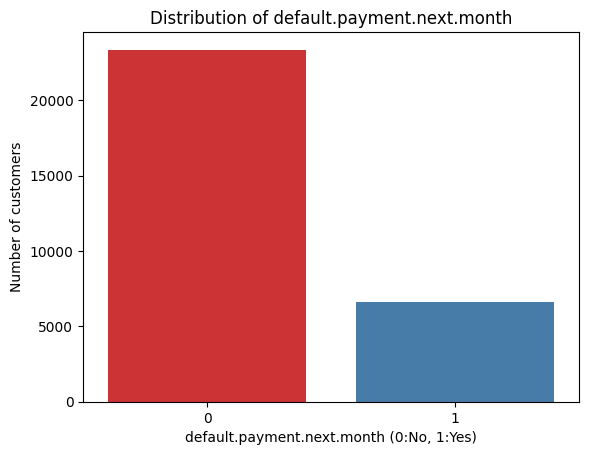

default.payment.next.month
0    77.88
1    22.12
Name: proportion, dtype: float64

In [945]:
defaut_counts=data['default.payment.next.month'].value_counts()

# Utiliser une palette valide ('Set1') ou une liste de couleurs
sns.countplot(x='default.payment.next.month', data=data, palette='Set1')
plt.title('Distribution of default.payment.next.month')
plt.xlabel('default.payment.next.month (0:No, 1:Yes)')
plt.ylabel('Number of customers')
plt.show()

class_percentages=data['default.payment.next.month'].value_counts(normalize=True)*100
class_percentages

<Axes: xlabel='default.payment.next.month', ylabel='Density'>

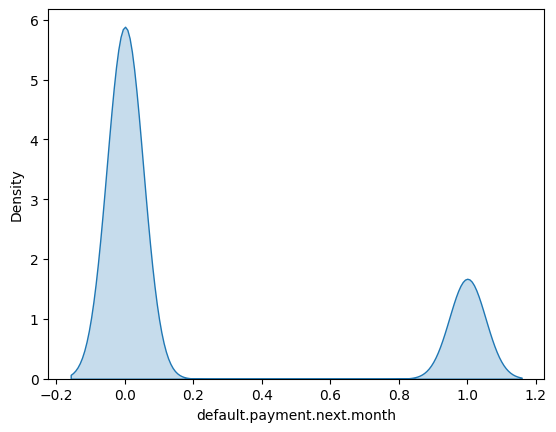

In [946]:
sns.kdeplot(data['default.payment.next.month'], fill=True)

In [947]:
from sklearn.ensemble import IsolationForest

# Supprimer les colonnes non numériques
data_numeric = data.select_dtypes(include=['number'])  # Garder uniquement les colonnes numériques

# Appliquer l'Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = iso_forest.fit_predict(data_numeric)

# Ajouter les labels d'anomalie au DataFrame d'origine
data['outlier'] = outlier_labels

# Afficher les outliers
outliers = data[data['outlier'] == -1]
print("Outliers détectés:")
print(outliers)

# Compter le nombre total d'outliers détectés
total_outliers = len(outliers)
print("Nombre total d'outliers détectés:", total_outliers)

Outliers détectés:
       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
6       500000.0    1          1         2   29     -1     -1     -1     -1   
17      320000.0    1          1         1   49     -1     -1     -1     -1   
40      360000.0    1          1         2   33     -1     -1     -1     -1   
50       70000.0    1          3         2   42      1      2      2      2   
59      400000.0    2          1         1   29     -1     -1     -1     -1   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29988   250000.0    1          1         1   34     -1     -1     -1     -1   
29991   210000.0    1          1         1   34      3      2      2      2   
29994    80000.0    1          1         2   34      2      2      2      2   
29997    30000.0    1          1         2   37      4      3      2     -1   
29998    80000.0    1          3         1   41      1     -1     -1     -1   

       PAY_5  ...  BILL_AMT5  BI

In [948]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

In [949]:
data=data.drop(columns=['outlier'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   PAY_0                       30000 non-null  int64  
 6   PAY_2                       30000 non-null  int64  
 7   PAY_3                       30000 non-null  int64  
 8   PAY_4                       30000 non-null  int64  
 9   PAY_5                       30000 non-null  int64  
 10  PAY_6                       30000 non-null  int64  
 11  BILL_AMT1                   30000 non-null  float64
 12  BILL_AMT2                   30000 non-null  float64
 13  BILL_AMT3                   300

In [950]:
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [951]:
# 1 pour femme et 0 pour homme
data['SEX']=data['SEX'].replace({1:0, 2:1})

In [952]:
data['SEX'].unique()

array([1, 0])

In [953]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

nominal_cols = ['EDUCATION', 'MARRIAGE']   # SEX déjà binaire

# 3) Appliquer ta logique nunique > 2
remaining_cat_vars = data[nominal_cols].nunique()
remaining_cat_vars = remaining_cat_vars[remaining_cat_vars > 2].index.to_list()

remaining_columns_dummies = pd.get_dummies(
    data=data[remaining_cat_vars],
    columns=remaining_cat_vars,
    dtype=int
)

remaining_columns_dummies.head()

,EDUCATION_1,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,1,0,0,1,0,0
1,1,0,0,0,1,0
2,1,0,0,0,1,0
3,1,0,0,1,0,0
4,1,0,0,1,0,0


In [954]:
others_vars = data.columns.difference(nominal_cols)

data1 = pd.concat(
    [
        data[others_vars],
        remaining_columns_dummies
    ],
    axis=1
)

data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AGE                         30000 non-null  int64  
 1   BILL_AMT1                   30000 non-null  float64
 2   BILL_AMT2                   30000 non-null  float64
 3   BILL_AMT3                   30000 non-null  float64
 4   BILL_AMT4                   30000 non-null  float64
 5   BILL_AMT5                   30000 non-null  float64
 6   BILL_AMT6                   30000 non-null  float64
 7   LIMIT_BAL                   30000 non-null  float64
 8   PAY_0                       30000 non-null  int64  
 9   PAY_2                       30000 non-null  int64  
 10  PAY_3                       30000 non-null  int64  
 11  PAY_4                       30000 non-null  int64  
 12  PAY_5                       30000 non-null  int64  
 13  PAY_6                       300

# Architecture des données

In [955]:
# Séparation des données en apprentissage et test

X, y = data1.drop(columns=['default.payment.next.month']), data1['default.payment.next.month'] 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)    

In [956]:
# Fréquence dans y
pd.DataFrame(y).value_counts(normalize=True)

default.payment.next.month
0                             0.7788
1                             0.2212
Name: proportion, dtype: float64

In [957]:
# Fréquence dans y_train
pd.DataFrame(y_train).value_counts(normalize=True)

default.payment.next.month
0                             0.778792
1                             0.221208
Name: proportion, dtype: float64

In [958]:
# Fréquence dans y_test
pd.DataFrame(y_test).value_counts(normalize=True)

default.payment.next.month
0                             0.778833
1                             0.221167
Name: proportion, dtype: float64

In [959]:
# Résolution du Problème de déséquilibre de classe par la méthode
# de sur-échantillonage de la classe minoritaire
X2 = X_train
X2['default.payment.next.month'] = y_train.values
minority = X2[X2['default.payment.next.month'] == 1]
majority = X2[X2['default.payment.next.month'] == 0]
minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
up_sampled = pd.concat([majority, minority_upsampled])
up_sampled

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,LIMIT_BAL,PAY_0,PAY_2,...,PAY_AMT5,PAY_AMT6,SEX,EDUCATION_1,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,default.payment.next.month
22788,33,161771.0,172632.0,168541.0,164310.0,162681.0,163005.0,160000.0,2,2,...,12300.0,6100.0,1,1,0,0,0,1,0,0
29006,34,0.0,53.0,0.0,0.0,0.0,0.0,150000.0,1,-1,...,0.0,0.0,1,1,0,0,0,1,0,0
16950,50,10171.0,8150.0,8446.0,8067.0,8227.0,8400.0,10000.0,1,2,...,305.0,1000.0,0,1,0,0,1,0,0,0
11346,32,0.0,0.0,326.0,326.0,-235.0,-235.0,310000.0,1,-1,...,0.0,1200.0,1,1,0,0,0,1,0,0
28654,33,18195.0,755.0,44255.0,43228.0,-772.0,-772.0,160000.0,-1,2,...,0.0,3000.0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12456,37,0.0,0.0,0.0,0.0,0.0,0.0,370000.0,-1,-1,...,0.0,0.0,1,0,1,0,1,0,0,1
8104,39,136007.0,139215.0,146127.0,143637.0,154531.0,147016.0,260000.0,2,-1,...,0.0,0.0,1,1,0,0,1,0,0,1
13440,23,33699.0,34766.0,33903.0,36266.0,36935.0,33441.0,40000.0,2,2,...,0.0,1400.0,1,1,0,0,0,1,0,1
20028,43,0.0,0.0,0.0,0.0,0.0,0.0,210000.0,1,-1,...,0.0,0.0,1,1,0,0,1,0,0,1


In [960]:
# Vérification de frquence dans Exited
up_sampled['default.payment.next.month'].value_counts(normalize=True)

default.payment.next.month
0    0.5
1    0.5
Name: proportion, dtype: float64

In [961]:
# Données d'entrainement sur la base de la méthode de sur-échantionnage de la classe minoritaire
X_train_up = up_sampled.drop(['default.payment.next.month'], axis = 1)
y_train_up = up_sampled['default.payment.next.month']

In [962]:
# Résolution du problème de déséquilibre de classe par la méthode de
#sous-échantillonnage de la classe majoritaire

majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=42)
down_sampled=pd.concat([minority, majority_downsampled])
down_sampled

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,LIMIT_BAL,PAY_0,PAY_2,...,PAY_AMT5,PAY_AMT6,SEX,EDUCATION_1,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,default.payment.next.month
22280,29,206879.0,211037.0,215139.0,218513.0,131660.0,134346.0,220000.0,-1,-1,...,4900.0,6000.0,1,1,0,0,0,1,0,1
4102,36,5367.0,6959.0,6649.0,5149.0,13750.0,5777.0,240000.0,-1,-1,...,0.0,726.0,1,1,0,0,0,1,0,1
26150,34,47904.0,48240.0,48602.0,46289.0,44837.0,44535.0,50000.0,3,3,...,2000.0,1500.0,1,1,0,0,1,0,0,1
4144,42,660.0,1320.0,660.0,1320.0,1320.0,1710.0,200000.0,-1,-1,...,1710.0,27077.0,1,1,0,0,0,1,0,1
173,24,-709.0,-709.0,-709.0,-2898.0,-3272.0,-3272.0,50000.0,1,-1,...,0.0,0.0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22498,38,1242.0,0.0,0.0,0.0,0.0,0.0,150000.0,-1,-1,...,0.0,0.0,1,1,0,0,0,1,0,0
29367,26,25993.0,6296.0,17223.0,18305.0,0.0,0.0,30000.0,-1,-1,...,0.0,0.0,0,1,0,0,0,1,0,0
23651,34,1915.0,6136.0,0.0,28642.0,4098.0,19024.0,290000.0,-1,-1,...,19426.0,0.0,1,1,0,0,0,1,0,0
5463,25,4471.0,5747.0,5509.0,6260.0,7654.0,8522.0,30000.0,-1,2,...,1000.0,800.0,1,1,0,0,0,1,0,0


In [963]:
# Vérification
down_sampled['default.payment.next.month'].value_counts(normalize=True)

default.payment.next.month
1    0.5
0    0.5
Name: proportion, dtype: float64

In [964]:
# Données d'entrainement sur la base de la méthode de sous-échantilonnage de la classe majoritaire
X_train_down=down_sampled.drop(['default.payment.next.month'], axis=1)
y_train_down=down_sampled['default.payment.next.month']

In [965]:
y_train=X_train['default.payment.next.month']
X_train=X_train.drop(['default.payment.next.month'], axis=1)

In [966]:
# Données d'entrainement
# Choix possibles: (X_train, y_train), (X_train_up, y_train_up),(X_train_down, y_train_down)
train_features = X_train_up
train_labels = y_train_up

In [967]:
# Normalisation des variables indépendantes des différents ensembles des données
 # On pourrait choisir de standardiser au lieu de normaliser

scaler = MinMaxScaler()
mod_scaler=scaler.fit(train_features)
train_features=mod_scaler.transform(train_features)
X_test=mod_scaler.transform(X_test)

# Retransformation en dataframe
train_features=pd.DataFrame(train_features, columns=X.columns)
X_test=pd.DataFrame(X_test, columns=X.columns)

In [968]:
train_features.describe()

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,LIMIT_BAL,PAY_0,PAY_2,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,EDUCATION_1,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
count,37382.000000,37382.000000,37382.000000,37382.000000,37382.000000,37382.000000,37382.000000,37382.000000,37382.000000,37382.000000,...,37382.000000,37382.000000,37382.000000,37382.00000,37382.000000,37382.000000,37382.000000,37382.000000,37382.000000,37382.000000
mean,0.269710,0.190669,0.111839,0.117201,0.127247,0.119952,0.211240,0.145412,0.098300,0.080107,...,0.006828,0.010228,0.008655,0.59114,0.817533,0.170296,0.012172,0.464475,0.521829,0.013696
std,0.173722,0.064868,0.067092,0.074092,0.065636,0.059757,0.050175,0.127219,0.148891,0.151048,...,0.022498,0.035488,0.030842,0.49163,0.386235,0.375898,0.109653,0.498743,0.499530,0.116229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.129630,0.149485,0.068940,0.069956,0.085951,0.082317,0.179622,0.040404,0.000000,0.000000,...,0.000023,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.165228,0.085700,0.088747,0.103072,0.098616,0.193309,0.111111,0.000000,0.000000,...,0.002027,0.003048,0.002270,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.388889,0.202598,0.123983,0.130138,0.136820,0.129262,0.219755,0.212121,0.222222,0.000000,...,0.005723,0.008567,0.006639,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [969]:
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.model_selection import GridSearchCV
 
#Definir les paramètres à estimer à l'aide de GridSearch
#param_grid_rf={
    #'n_estimators':[200,300,500],
    #'max_depth': [20,23,None]
#}

#grid_search_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                            #param_grid=param_grid_rf,
                            #scoring='f1',
                            #oob_score=True,
                            #cv=5)
# créer un modèle de forêt aléatoire
# Note: grid_rf_class is not defined, assuming you meant grid_search_rf
#rf_model=grid_search_rf.fit(train_features, train_labels)
#print(round(rf_model.best_score_,3))
#print(rf_model.best_estimator_)
#print(rf_model.best_params_)      # Seulement les meilleurs hyperparamètres testés
#print(rf_model.best_estimator_.get_params())  # Tous les hyperparamètres du modèle

In [970]:
#from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score

#print("Best CV F1 (GridSearch):", round(rf_model.best_score_,3))

# -----------------------
# Évaluation sur l'ensemble d'entraînement
# -----------------------
# Predictions sur le jeu d'entraînement
#y_train_pred = rf_model.predict(train_features)
#try:
    #y_train_proba = rf_model.predict_proba(train_features)[:,1]
#except Exception:
    #y_train_proba = None

#print("Train F1 (binaire) :", round(f1_score(train_labels, y_train_pred),3))
#print("Train Precision :", round(precision_score(train_labels, y_train_pred),3))
#print("Train Recall :", round(recall_score(train_labels, y_train_pred),3))
#if y_train_proba is not None:
    #print("Train ROC AUC :", round(roc_auc_score(train_labels, y_train_proba),3))

#print("\nClassification report (train):\n", classification_report(train_labels, y_train_pred, digits=3))
#cm_train = confusion_matrix(train_labels, y_train_pred)
#print("Confusion matrix (train):\n", cm_train)
#cm_train_norm = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
#print("Confusion matrix (train) (normalisée par ligne) :\n", np.round(cm_train_norm,3))

# -----------------------
# Évaluation sur l'ensemble de test
# -----------------------
# Predictions sur le jeu de test
#y_pred = rf_model.predict(X_test)
#try:
    #y_proba = rf_model.predict_proba(X_test)[:,1]
#except Exception:
    #y_proba = None

#print("\nTest F1 (binaire) :", round(f1_score(y_test, y_pred),3))
#print("Test F1 (macro) :", round(f1_score(y_test, y_pred, average='macro'),3))
#print("Precision (test) :", round(precision_score(y_test, y_pred),3))
#print("Recall (test) :", round(recall_score(y_test, y_pred),3))
#if y_proba is not None:
    #print("ROC AUC (test) :", round(roc_auc_score(y_test, y_proba),3))

#print("\nClassification report (test):\n", classification_report(y_test, y_pred, digits=3))

#cm = confusion_matrix(y_test, y_pred)
#print("Confusion matrix (test):\n", cm)
#cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#print("Confusion matrix (test) (normalisée par ligne) :\n", np.round(cm_norm,3))

# Summary comparison
#print("\nRésumé :")
#train_f1 = round(f1_score(train_labels, y_train_pred),3)
#test_f1 = round(f1_score(y_test, y_pred),3)
#print(f" F1 train = {train_f1}  |  F1 test = {test_f1}  |  CV F1 (GridSearch) = {round(rf_model.best_score_,3)}")

#if train_f1 - test_f1 > 0.05:
    #print("Remarque: F1 train >> F1 test → suspicion de surapprentissage (overfitting). Considérer régularisation, plus de données, ou réduire la complexité du modèle.")
#elif test_f1 - train_f1 > 0.05:
    #print("Remarque: F1 test > F1 train — vérifier le calcul, ou ceci peut arriver si le jeu d'entraînement est plus bruité (rare).")
#else:
    #print("Remarque: performances train/test proches — pas d'indication claire de surapprentissage.")

In [971]:
#from sklearn.metrics import f1_score, classification_report, confusion_matrix
#y_test_pred = rf_model.best_estimator_.predict(X_test)

#print("Classification Report:")
#print(classification_report(y_test, y_test_pred))

#print("Confusion Matrix:")
#print(confusion_matrix(y_test, y_test_pred))

In [972]:
# Classificateur Perceptron Multicouche (ou model de classification avec reseaux de neurones)
#mlp=MLPClassifier(random_state=42, max_iter=1000)
#parameters={'hidden_layer_sizes':[(50,),(100,),(200,)], 'activation': ['identity', 'logistic', 'tanh', 'relu'],
            #'learning_rate': ['constant', 'invscaling', 'adaptive']} # Corrected typo here

#mlp_cv=GridSearchCV(mlp, parameters, scoring='f1', cv=5, n_jobs=-1) # Corrected class name
#mlp_cv.fit(train_features, train_labels)

In [973]:
#round(mlp_cv.best_score_,3)

In [974]:
#mlp_cv.best_params_

In [975]:
# Évaluation du meilleur modèle MLP (train vs test)
#print("MLP CV best score:", round(mlp_cv.best_score_,3))
#print("MLP best params:", mlp_cv.best_params_)

#best_mlp = mlp_cv.best_estimator_

# --- Train
#y_train_pred_mlp = best_mlp.predict(train_features)
#try:
    #y_train_proba_mlp = best_mlp.predict_proba(train_features)[:,1]
#except Exception:
    #y_train_proba_mlp = None

#print("\nTrain F1:", round(f1_score(train_labels, y_train_pred_mlp),3))
#print("Train Precision:", round(precision_score(train_labels, y_train_pred_mlp),3))
#print("Train Recall:", round(recall_score(train_labels, y_train_pred_mlp),3))
#if y_train_proba_mlp is not None:
    #print("Train ROC AUC:", round(roc_auc_score(train_labels, y_train_proba_mlp),3))

#print("\nClassification report (train):\n", classification_report(train_labels, y_train_pred_mlp, digits=3))
#cm_train_mlp = confusion_matrix(train_labels, y_train_pred_mlp)
#print("Confusion matrix (train):\n", cm_train_mlp)
#print("Confusion matrix (train) (normalized):\n", np.round(cm_train_mlp.astype('float') / cm_train_mlp.sum(axis=1)[:, np.newaxis],3))

# --- Test
#y_test_pred_mlp = best_mlp.predict(X_test)
#try:
    #y_test_proba_mlp = best_mlp.predict_proba(X_test)[:,1]
#except Exception:
    #y_test_proba_mlp = None

#print("\nTest F1:", round(f1_score(y_test, y_test_pred_mlp),3))
#print("Test Precision:", round(precision_score(y_test, y_test_pred_mlp),3))
#print("Test Recall:", round(recall_score(y_test, y_test_pred_mlp),3))
#if y_test_proba_mlp is not None:
    #print("Test ROC AUC:", round(roc_auc_score(y_test, y_test_proba_mlp),3))

#print("\nClassification report (test):\n", classification_report(y_test, y_test_pred_mlp, digits=3))
#cm_test_mlp = confusion_matrix(y_test, y_test_pred_mlp)
#print("Confusion matrix (test):\n", cm_test_mlp)
#print("Confusion matrix (test) (normalized):\n", np.round(cm_test_mlp.astype('float') / cm_test_mlp.sum(axis=1)[:, np.newaxis],3))

# Résumé et remarque
#train_f1_mlp = round(f1_score(train_labels, y_train_pred_mlp),3)
#test_f1_mlp = round(f1_score(y_test, y_test_pred_mlp),3)
#print(f"\nRésumé MLP : F1 train = {train_f1_mlp} | F1 test = {test_f1_mlp} | CV F1 = {round(mlp_cv.best_score_,3)}")
#if train_f1_mlp - test_f1_mlp > 0.05:
    #print("Remarque: surapprentissage possible.")
#else:
    #print("Remarque: écart train/test raisonnable.")

# Plot confusion matrices
#import matplotlib.pyplot as plt
#import seaborn as sns
#plt.figure(figsize=(12,5))
#plt.subplot(1,2,1)
#sns.heatmap(cm_train_mlp, annot=True, fmt='d', cmap='Blues')
#plt.title('Confusion matrix - Train (MLP)')
#plt.xlabel('Pred')
#plt.ylabel('True')

#plt.subplot(1,2,2)
#sns.heatmap(cm_test_mlp, annot=True, fmt='d', cmap='Oranges')
#plt.title('Confusion matrix - Test (MLP)')
#plt.xlabel('Pred')
#plt.ylabel('True')
#plt.tight_layout()
#plt.show()

In [976]:
#from sklearn.metrics import f1_score, classification_report, confusion_matrix
#y_test_pred = mlp_cv.best_estimator_.predict(X_test)

#print("Classification Report:")
#print(classification_report(y_test, y_test_pred))

#print("Confusion Matrix:")
#print(confusion_matrix(y_test, y_test_pred))

In [977]:
from sklearn.linear_model import LogisticRegression
param_grid={'C': [0.001,0.01,0.1,1,10]}

grid_logreg_class=GridSearchCV(estimator=LogisticRegression(random_state=42, max_iter=5000),
                                param_grid=param_grid,
                                scoring='f1', cv=5)

logreg_model=grid_logreg_class.fit(train_features, train_labels)

In [978]:
print(logreg_model.best_params_)      # Seulement les meilleurs hyperparamètres testés
print(logreg_model.best_estimator_.get_params())  # Tous les hyperparamètres du modèle

{'C': 0.1}
{'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 5000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


LogReg CV best score: 0.657
LogReg best params: {'C': 0.1}

Train F1: 0.657
Train Precision: 0.774
Train Recall: 0.57
Train ROC AUC: 0.76

Classification report (train):
               precision    recall  f1-score   support

           0      0.660     0.833     0.737     18691
           1      0.774     0.570     0.657     18691

    accuracy                          0.702     37382
   macro avg      0.717     0.702     0.697     37382
weighted avg      0.717     0.702     0.697     37382

Confusion matrix (train):
 [[15578  3113]
 [ 8028 10663]]
Confusion matrix (train) (normalized):
 [[0.833 0.167]
 [0.43  0.57 ]]

Test F1: 0.517
Test Precision: 0.489
Test Recall: 0.549
Test ROC AUC: 0.741

Classification report (test):
               precision    recall  f1-score   support

           0      0.867     0.837     0.852      4673
           1      0.489     0.549     0.517      1327

    accuracy                          0.773      6000
   macro avg      0.678     0.693     0.684   

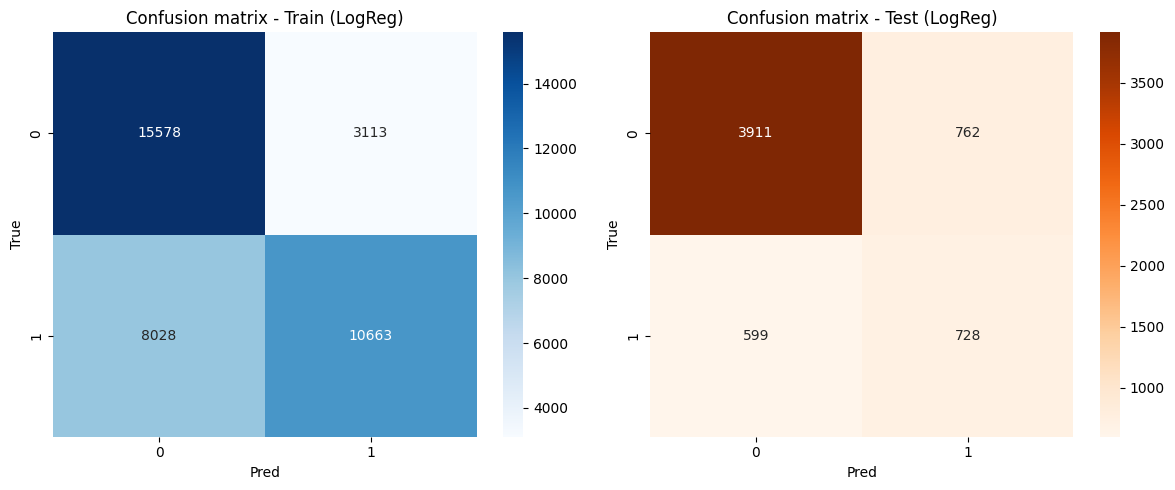

In [979]:
# Évaluation du meilleur modèle Logistic Regression (train vs test)
print("LogReg CV best score:", round(logreg_model.best_score_,3))
print("LogReg best params:", logreg_model.best_params_)

best_lr = logreg_model.best_estimator_

# --- Train
y_train_pred_lr = best_lr.predict(train_features)
try:
    y_train_proba_lr = best_lr.predict_proba(train_features)[:,1]
except Exception:
    y_train_proba_lr = None

print("\nTrain F1:", round(f1_score(train_labels, y_train_pred_lr),3))
print("Train Precision:", round(precision_score(train_labels, y_train_pred_lr),3))
print("Train Recall:", round(recall_score(train_labels, y_train_pred_lr),3))
if y_train_proba_lr is not None:
    print("Train ROC AUC:", round(roc_auc_score(train_labels, y_train_proba_lr),3))

print("\nClassification report (train):\n", classification_report(train_labels, y_train_pred_lr, digits=3))
cm_train_lr = confusion_matrix(train_labels, y_train_pred_lr)
print("Confusion matrix (train):\n", cm_train_lr)
print("Confusion matrix (train) (normalized):\n", np.round(cm_train_lr.astype('float') / cm_train_lr.sum(axis=1)[:, np.newaxis],3))

# --- Test
y_test_pred_lr = best_lr.predict(X_test)
try:
    y_test_proba_lr = best_lr.predict_proba(X_test)[:,1]
except Exception:
    y_test_proba_lr = None

print("\nTest F1:", round(f1_score(y_test, y_test_pred_lr),3))
print("Test Precision:", round(precision_score(y_test, y_test_pred_lr),3))
print("Test Recall:", round(recall_score(y_test, y_test_pred_lr),3))
if y_test_proba_lr is not None:
    print("Test ROC AUC:", round(roc_auc_score(y_test, y_test_proba_lr),3))

print("\nClassification report (test):\n", classification_report(y_test, y_test_pred_lr, digits=3))
cm_test_lr = confusion_matrix(y_test, y_test_pred_lr)
print("Confusion matrix (test):\n", cm_test_lr)
print("Confusion matrix (test) (normalized):\n", np.round(cm_test_lr.astype('float') / cm_test_lr.sum(axis=1)[:, np.newaxis],3))

# Résumé et remarque
train_f1_lr = round(f1_score(train_labels, y_train_pred_lr),3)
test_f1_lr = round(f1_score(y_test, y_test_pred_lr),3)
print(f"\nRésumé LR : F1 train = {train_f1_lr} | F1 test = {test_f1_lr} | CV F1 = {round(logreg_model.best_score_,3)}")
if train_f1_lr - test_f1_lr > 0.05:
    print("Remarque: surapprentissage possible.")
else:
    print("Remarque: écart train/test raisonnable.")

# Plot confusion matrices
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(cm_train_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix - Train (LogReg)')
plt.xlabel('Pred')
plt.ylabel('True')

plt.subplot(1,2,2)
sns.heatmap(cm_test_lr, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion matrix - Test (LogReg)')
plt.xlabel('Pred')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [980]:
#model_evaluation(mlp_cv.best_estimator_, X_test, y_test)

In [981]:
#from sklearn.metrics import f1_score, classification_report, confusion_matrix
y_test_pred = best_lr.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4673
           1       0.49      0.55      0.52      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.69      0.68      6000
weighted avg       0.78      0.77      0.78      6000

Confusion Matrix:
[[3911  762]
 [ 599  728]]
ROC AUC: 0.736726123600262


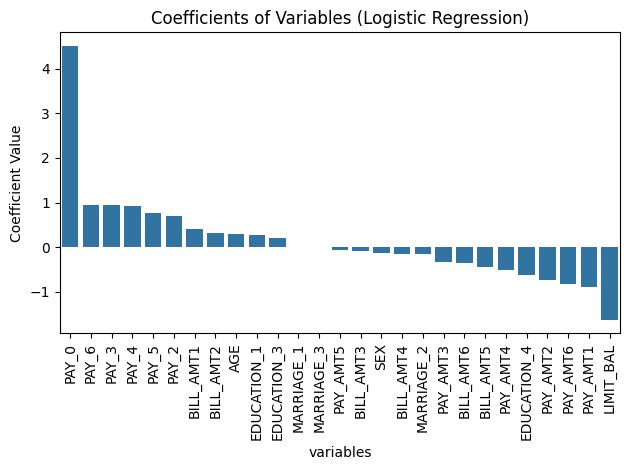

In [982]:
vars_imp=pd.Series(best_lr.coef_[0], index=train_features.columns).sort_values(ascending=False)

sns.barplot(x=vars_imp.index, y=vars_imp)
plt.xlabel("variables")
plt.ylabel("Coefficient Value") # Changed label to reflect coefficients
plt.title("Coefficients of Variables (Logistic Regression)") # Changed title
plt.xticks(rotation=90) # Added to prevent x-axis labels from overlapping
plt.tight_layout() # Added to adjust layout
plt.show()

### Sauvegarde du modèle

In [983]:
# Suvegarde du modèle finale: best_lr
joblib.dump(best_lr, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

## Régression logistique avec penalité l1

In [984]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr = LogisticRegression(
    penalty='l1',
    solver='saga',
    class_weight='balanced',
    max_iter=500,
    random_state=42
)

param_grid = {
    "C": np.logspace(-3, 1, 9)  # 0.001 -> 10
}

grid = GridSearchCV(
    lr,
    param_grid=param_grid,
    scoring="f1",   # f1 pour la classe 1
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(train_features, train_labels)

print("Best CV F1:", grid.best_score_)
print("Best params:", grid.best_params_)

best_lr_l1 = grid.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best CV F1: 0.6566575019583428
Best params: {'C': np.float64(3.1622776601683795)}


In [985]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = best_lr_l1.predict(X_test)
y_proba = best_lr_l1.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4673
           1       0.49      0.55      0.52      1327

    accuracy                           0.77      6000
   macro avg       0.68      0.69      0.68      6000
weighted avg       0.78      0.77      0.78      6000

[[3905  768]
 [ 595  732]]
ROC AUC: 0.7447081318694786


# Création des modèles evec RFE

## Régression logistique avec penalité L2

In [986]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

lr = LogisticRegression(
    penalty='l2',   # recommandé pour RFE
    solver='lbfgs',
    max_iter=5000,
    class_weight='balanced'
)


In [987]:
rfe = RFE(
    estimator=lr,
    n_features_to_select=20,   # à tester
    step=1
)

rfe.fit(train_features, train_labels)


,estimator,LogisticRegre...max_iter=5000)
,n_features_to_select,20
,step,1
,verbose,0
,importance_getter,'auto'
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


In [988]:
selected_features = train_features.columns[rfe.support_]
print("Variables sélectionnées :", selected_features)


Variables sélectionnées : Index(['AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'EDUCATION_4'],
      dtype='object')


In [989]:
X_train_rfe = train_features[selected_features]
X_test_rfe = X_test[selected_features]

lr.fit(X_train_rfe, train_labels)

y_pred = lr.predict(X_test_rfe)


In [990]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

rfecv = RFECV(
    estimator=lr,
    step=1,
    cv=StratifiedKFold(5),
    scoring='f1'
)

rfecv.fit(train_features, train_labels)

print("Nombre optimal de variables :", rfecv.n_features_)


Nombre optimal de variables : 8


In [991]:
# 1) Récupérer les features sélectionnées
selected_features = train_features.columns[rfecv.support_]
print("Nombre de variables sélectionnées :", len(selected_features))
print("Variables sélectionnées :")
print(selected_features.tolist())

Nombre de variables sélectionnées : 8
Variables sélectionnées :
['LIMIT_BAL', 'PAY_0', 'PAY_3', 'PAY_5', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT6']


In [992]:
# 2) Créer les nouveaux jeux de données réduits
X_train_sel = train_features[selected_features]
X_test_sel  = X_test[selected_features]

# 3) Ré-entraîner un modèle final sur ces variables
# (On réutilise lr, ou on le recrée avec tes paramètres)
lr_final = LogisticRegression(
    penalty='l2',              # ou 'l1' si tu veux (voir remarque plus bas)
    solver='lbfgs',            # l2 -> lbfgs OK ; l1 -> saga
    class_weight='balanced',
    max_iter=5000,
    random_state=42
)

lr_final.fit(X_train_sel, train_labels)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [993]:
# 4) Évaluer sur le test
y_pred = lr_final.predict(X_test_sel)
y_proba = lr_final.predict_proba(X_test_sel)[:, 1]

print("\nF1 test (classe 1):", f1_score(y_test, y_pred))
print("ROC AUC test:", roc_auc_score(y_test, y_proba))

print("\nClassification report (test):")
print(classification_report(y_test, y_pred))

print("Confusion matrix (test):")
print(confusion_matrix(y_test, y_pred))




F1 test (classe 1): 0.5136159944846604
ROC AUC test: 0.7367091104101211

Classification report (test):
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      4673
           1       0.47      0.56      0.51      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.69      0.68      6000
weighted avg       0.78      0.76      0.77      6000

Confusion matrix (test):
[[3844  829]
 [ 582  745]]


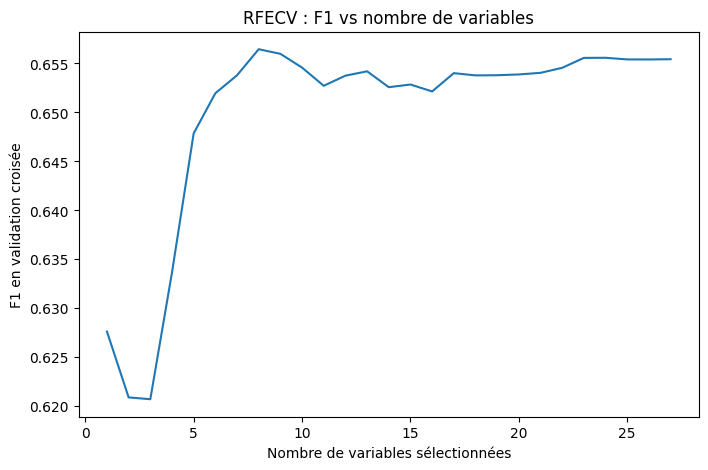

In [994]:
# 5) (Optionnel) Visualiser la performance CV selon le nb de variables
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
         rfecv.cv_results_["mean_test_score"])
plt.xlabel("Nombre de variables sélectionnées")
plt.ylabel("F1 en validation croisée")
plt.title("RFECV : F1 vs nombre de variables")
plt.show()

## Random Forest

In [995]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
 
#Definir les paramètres à estimer à l'aide de GridSearch
param_grid_rf={
    'n_estimators':[200,300,500],
    'max_depth': [20,23,None]
}

grid_search_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                            param_grid=param_grid_rf,
                            scoring='f1',
                            #oob_score=True,
                            cv=5)
# créer un modèle de forêt aléatoire
# Note: grid_rf_class is not defined, assuming you meant grid_search_rf
rf_model=grid_search_rf.fit(X_train_sel, train_labels)
print(round(rf_model.best_score_,3))
print(rf_model.best_estimator_)
print(rf_model.best_params_)      # Seulement les meilleurs hyperparamètres testés
print(rf_model.best_estimator_.get_params())  # Tous les hyperparamètres du modèle

0.919
RandomForestClassifier(n_estimators=200, random_state=42)
{'max_depth': None, 'n_estimators': 200}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [996]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
y_test_pred = rf_model.best_estimator_.predict(X_test_sel)

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      4673
           1       0.52      0.45      0.48      1327

    accuracy                           0.79      6000
   macro avg       0.68      0.66      0.67      6000
weighted avg       0.78      0.79      0.78      6000

Confusion Matrix:
[[4118  555]
 [ 732  595]]


In [997]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

dt = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42)
#)

param_grid = {
    "max_depth": [9,10,11, 12,None],
    "min_samples_split": [ 200, 500, 700],
    "min_samples_leaf": [10, 20,50],
    "criterion": ["gini", "entropy"],
    "ccp_alpha" : [0.0, 0.0001, 0.001, 0.01]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring="f1",      # si ta classe positive est 1, c'est bon
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(train_features, train_labels)

print("Best CV F1:", grid.best_score_)
print("Best params:", grid.best_params_)

best_dt = grid.best_estimator_


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best CV F1: 0.735088817179911
Best params: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 200}


In [998]:
# Afficher le score de la recherche et les paramètres
print("DT CV best score:", round(grid.best_score_, 3))
print("DT best params:", grid.best_params_)

# Récupérer le meilleur estimateur
best_dt = grid.best_estimator_

# --- Train
y_train_pred_dt = best_dt.predict(train_features)
try:
    y_train_proba_dt = best_dt.predict_proba(train_features)[:, 1]
except Exception:
    y_train_proba_dt = None

print("\nTrain F1:", round(f1_score(train_labels, y_train_pred_dt), 3))
print("Train Precision:", round(precision_score(train_labels, y_train_pred_dt), 3))
print("Train Recall:", round(recall_score(train_labels, y_train_pred_dt), 3))
if y_train_proba_dt is not None:
    print("Train ROC AUC:", round(roc_auc_score(train_labels, y_train_proba_dt), 3))

# --- Test
y_test_pred_dt = best_dt.predict(X_test)
try:
    y_test_proba_dt = best_dt.predict_proba(X_test)[:, 1]
except Exception:
    y_test_proba_dt = None

print("\nTest F1:", round(f1_score(y_test, y_test_pred_dt), 3))
print("Test Precision:", round(precision_score(y_test, y_test_pred_dt), 3))
print("Test Recall:", round(recall_score(y_test, y_test_pred_dt), 3))
if y_test_proba_dt is not None:
    print("Test ROC AUC:", round(roc_auc_score(y_test, y_test_proba_dt), 3))

# Résumé
train_f1_dt = round(f1_score(train_labels, y_train_pred_dt), 3)
test_f1_dt = round(f1_score(y_test, y_test_pred_dt), 3)
print(f"\nRésumé DT : F1 train = {train_f1_dt} | F1 test = {test_f1_dt} | CV F1 = {round(grid.best_score_, 3)}")

DT CV best score: 0.735
DT best params: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 200}

Train F1: 0.78
Train Precision: 0.763
Train Recall: 0.798
Train ROC AUC: 0.866

Test F1: 0.477
Test Precision: 0.386
Test Recall: 0.627
Test ROC AUC: 0.737

Résumé DT : F1 train = 0.78 | F1 test = 0.477 | CV F1 = 0.735


In [999]:
#from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79      4673
           1       0.39      0.63      0.48      1327

    accuracy                           0.70      6000
   macro avg       0.63      0.67      0.63      6000
weighted avg       0.76      0.70      0.72      6000

[[3347 1326]
 [ 495  832]]
ROC AUC: 0.736726123600262
